# Section 3.3 Single Model Numerical Diagnostics

In [1]:
import os

import arviz as az

# Change working directory
if os.path.split(os.getcwd())[-1] != "notebooks":
    os.chdir(os.path.join(".."))

NETCDF_DIR = "inference_data"

In [2]:
az.style.use('arviz-white')

## What happened to hard numbers?

One criticism of visual plots their interpretation is subjective. When running one model its relatively simple to visually inspect the results, but if testing out various models looking over many traceplots and autocorrelation diagrams becomes statistician time intensive. (We'll talk more about multiple models in Section 5). As far as it is possible to automate model checking, we would like to.


## $\hat{R}$ and Effective Sample Size

Recall our two pertinent questions MCMC practioners should ask when making posterior estimates:

* Did the chains mix well?
* Did we get enough samples?


These questions are paraphrased from the paper published in March 2019: **Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC** by [Vehtari et.al.](https://arxiv.org/abs/1903.08008), and thankfully the paper provides two numbers -- $\hat{R}$, and effective sample size (ESS) -- as tools to help answer these questions.

### Warning: Active Research Zone

Wow! A paper from 2019! Bayesian statistics is an academically active field and numerous versions of $\hat{R}$ and effective sample size calculations have been proposed over the years. the first of which was published in 1992. In this tutorial we will be covering the calucation from the 2019 paper (linked again [here]((https://arxiv.org/abs/1903.08008)))
Just be mindful that when looking at older papers or results the diagnostics will answer the same question, but the exact calculation may differ.

Some prior papers are linked here for reference.

[Gelman and Rubin (1992)](https://projecteuclid.org/euclid.ss/1177011136)  
[Brooks and Gelman (1998)](http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/BrooksGelman.pdf)  
[Gelman et al. Bayesian Data Analysis (3 ed, 2014)](http://www.stat.columbia.edu/~gelman/book/)



### $\hat{R}$ (say "R hat")
The first question we'll try and answer is if the chains have mixed well. The summarized formula is

$$ \Large \hat{R} = \sqrt{\frac{\hat{\text{var}}^{+}(\theta \mid y)}{W}}$$

While the details of the calculation can be found in the paper, it's using the *between chain variance* with *in chain variance* to calculate $\hat{R}$. The idea is that if all the chains have converged, the variance should be similar across all chains, and the pooled sample of all chains.

### Effective sample size (also known as ESS, also known as $S_{eff}$)

As the name suggests effective sample size helps answer the question "Did we get enough samples?" The summarized formula is  

$$ \large S_{\text{eff}} = \frac{NM}{\hat{\tau}} $$

Where N is computation draws, M is the number of chains and $\hat{\tau}$ is a number derived from the chain autocorrelations. The idea here is that in highly autocorrelated chains, while the computer *is* drawing samples they're not effective because they're not doing much to help estimate the posterior. 

Let's walk through an example

## Reliving the horror. Naive Metropolis Hastings with Bad Initialization
In Section 3.1 we performed an Inference Run with nightmareish results. Let's load the data again here and plot the visual diagnostics once again.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effaf8cdc18>,
      dtype=object)

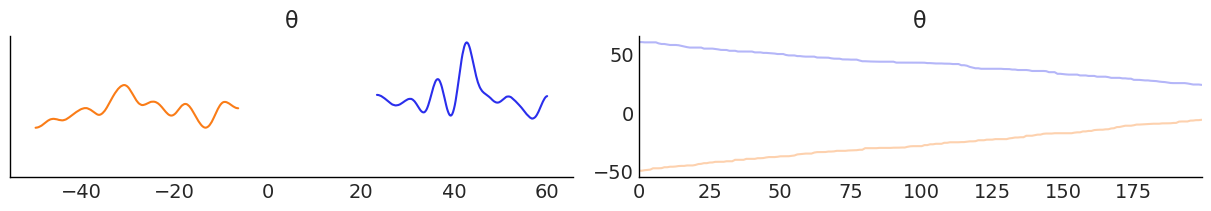

In [3]:
data_bad_init = az.from_netcdf(os.path.join(NETCDF_DIR, "data_bad_init.nc"))

az.plot_trace(data_bad_init)

Looking again at the trace plots we can "see" that the results look bad, but like true statisticians let's use our numerical tools to quantify the results.

In [4]:
az.rhat(data_bad_init)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    θ        float64 3.061

In [5]:
az.effective_sample_size(data_bad_init)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    θ        float64 2.335

According to the math $\hat{R} = 6.95$ and $S_{\text{eff}} = 2.33$, but this begs the question is this good or bad? Subjectively speaking these are bad. Generally speaking

* We want $\hat{R}$ to be to close to 1 as possible
* We want ESS to be as close to the number of simulation draws as possible  

$\hat{R}$ is telling us that the variances are not very consistent and $S_{\text{eff}}$ is telling us that the 400 draws (200 draws over 2 chains) we took were as useful as ~2 independent draws from the true distribution (for ESS this small, such an interpretation is necessarily silly).

In Aki's paper the advice there is specific advice for these diagnostics

* Run at least 4 chains
* $\hat{R}$ should be less than 1.01
* ESS should be 400 "before we expect $\hat{R}$ to be useful"

In Notebook 3.4 we'll be using $\hat{R}$ and $S_{\text{eff}}$ to compare each inference run